# Content

1. EDA
2. Data cleaning
3. Feature Engineering
4. Modeling & Evaluation
5. Model Ensemble

In [584]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import xgboost
import scipy.stats

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [585]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [586]:
train_raw = pd.read_csv('./train.csv')
test_raw = pd.read_csv('./test.csv')

# EDA

In [587]:
train_raw.shape, test_raw.shape

((1460, 81), (1459, 80))

In [588]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Target

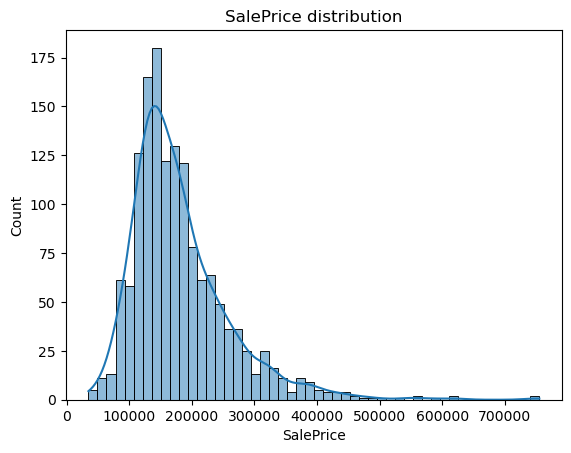

In [589]:
plt.figure()
sns.histplot(train_raw['SalePrice'], bins=50, kde=True)
plt.title('SalePrice distribution')
plt.show()

In [590]:
train_raw['SalePrice'].skew()

1.8828757597682129

- SalePrice is positive skewness, use log transformation to make it approximate normal distribution

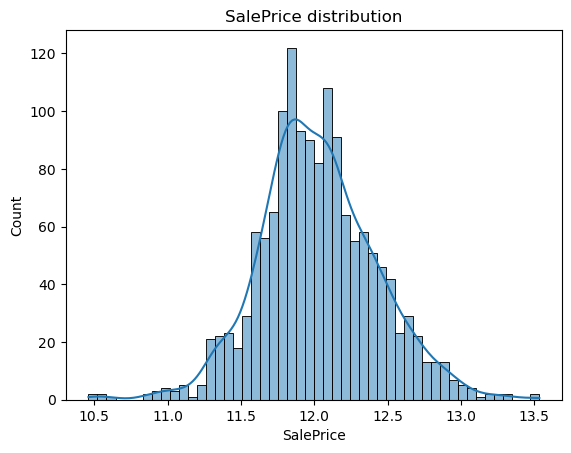

In [591]:
plt.figure()
sns.histplot(np.log1p(train_raw['SalePrice']), bins=50, kde=True)
plt.title('SalePrice distribution')
plt.show()

In [592]:
cate_features_eda = [col for col in train_raw.columns if train_raw[col].dtype == 'object']
num_features_eda = [col for col in train_raw.columns if train_raw[col].dtype == 'int64' or \
                      train_raw[col].dtype == 'float64']

num_features_eda.remove('Id')
num_features_eda.remove('SalePrice')

In [593]:
len(cate_features_eda), len(num_features_eda)

(43, 36)

## Categorical featrues

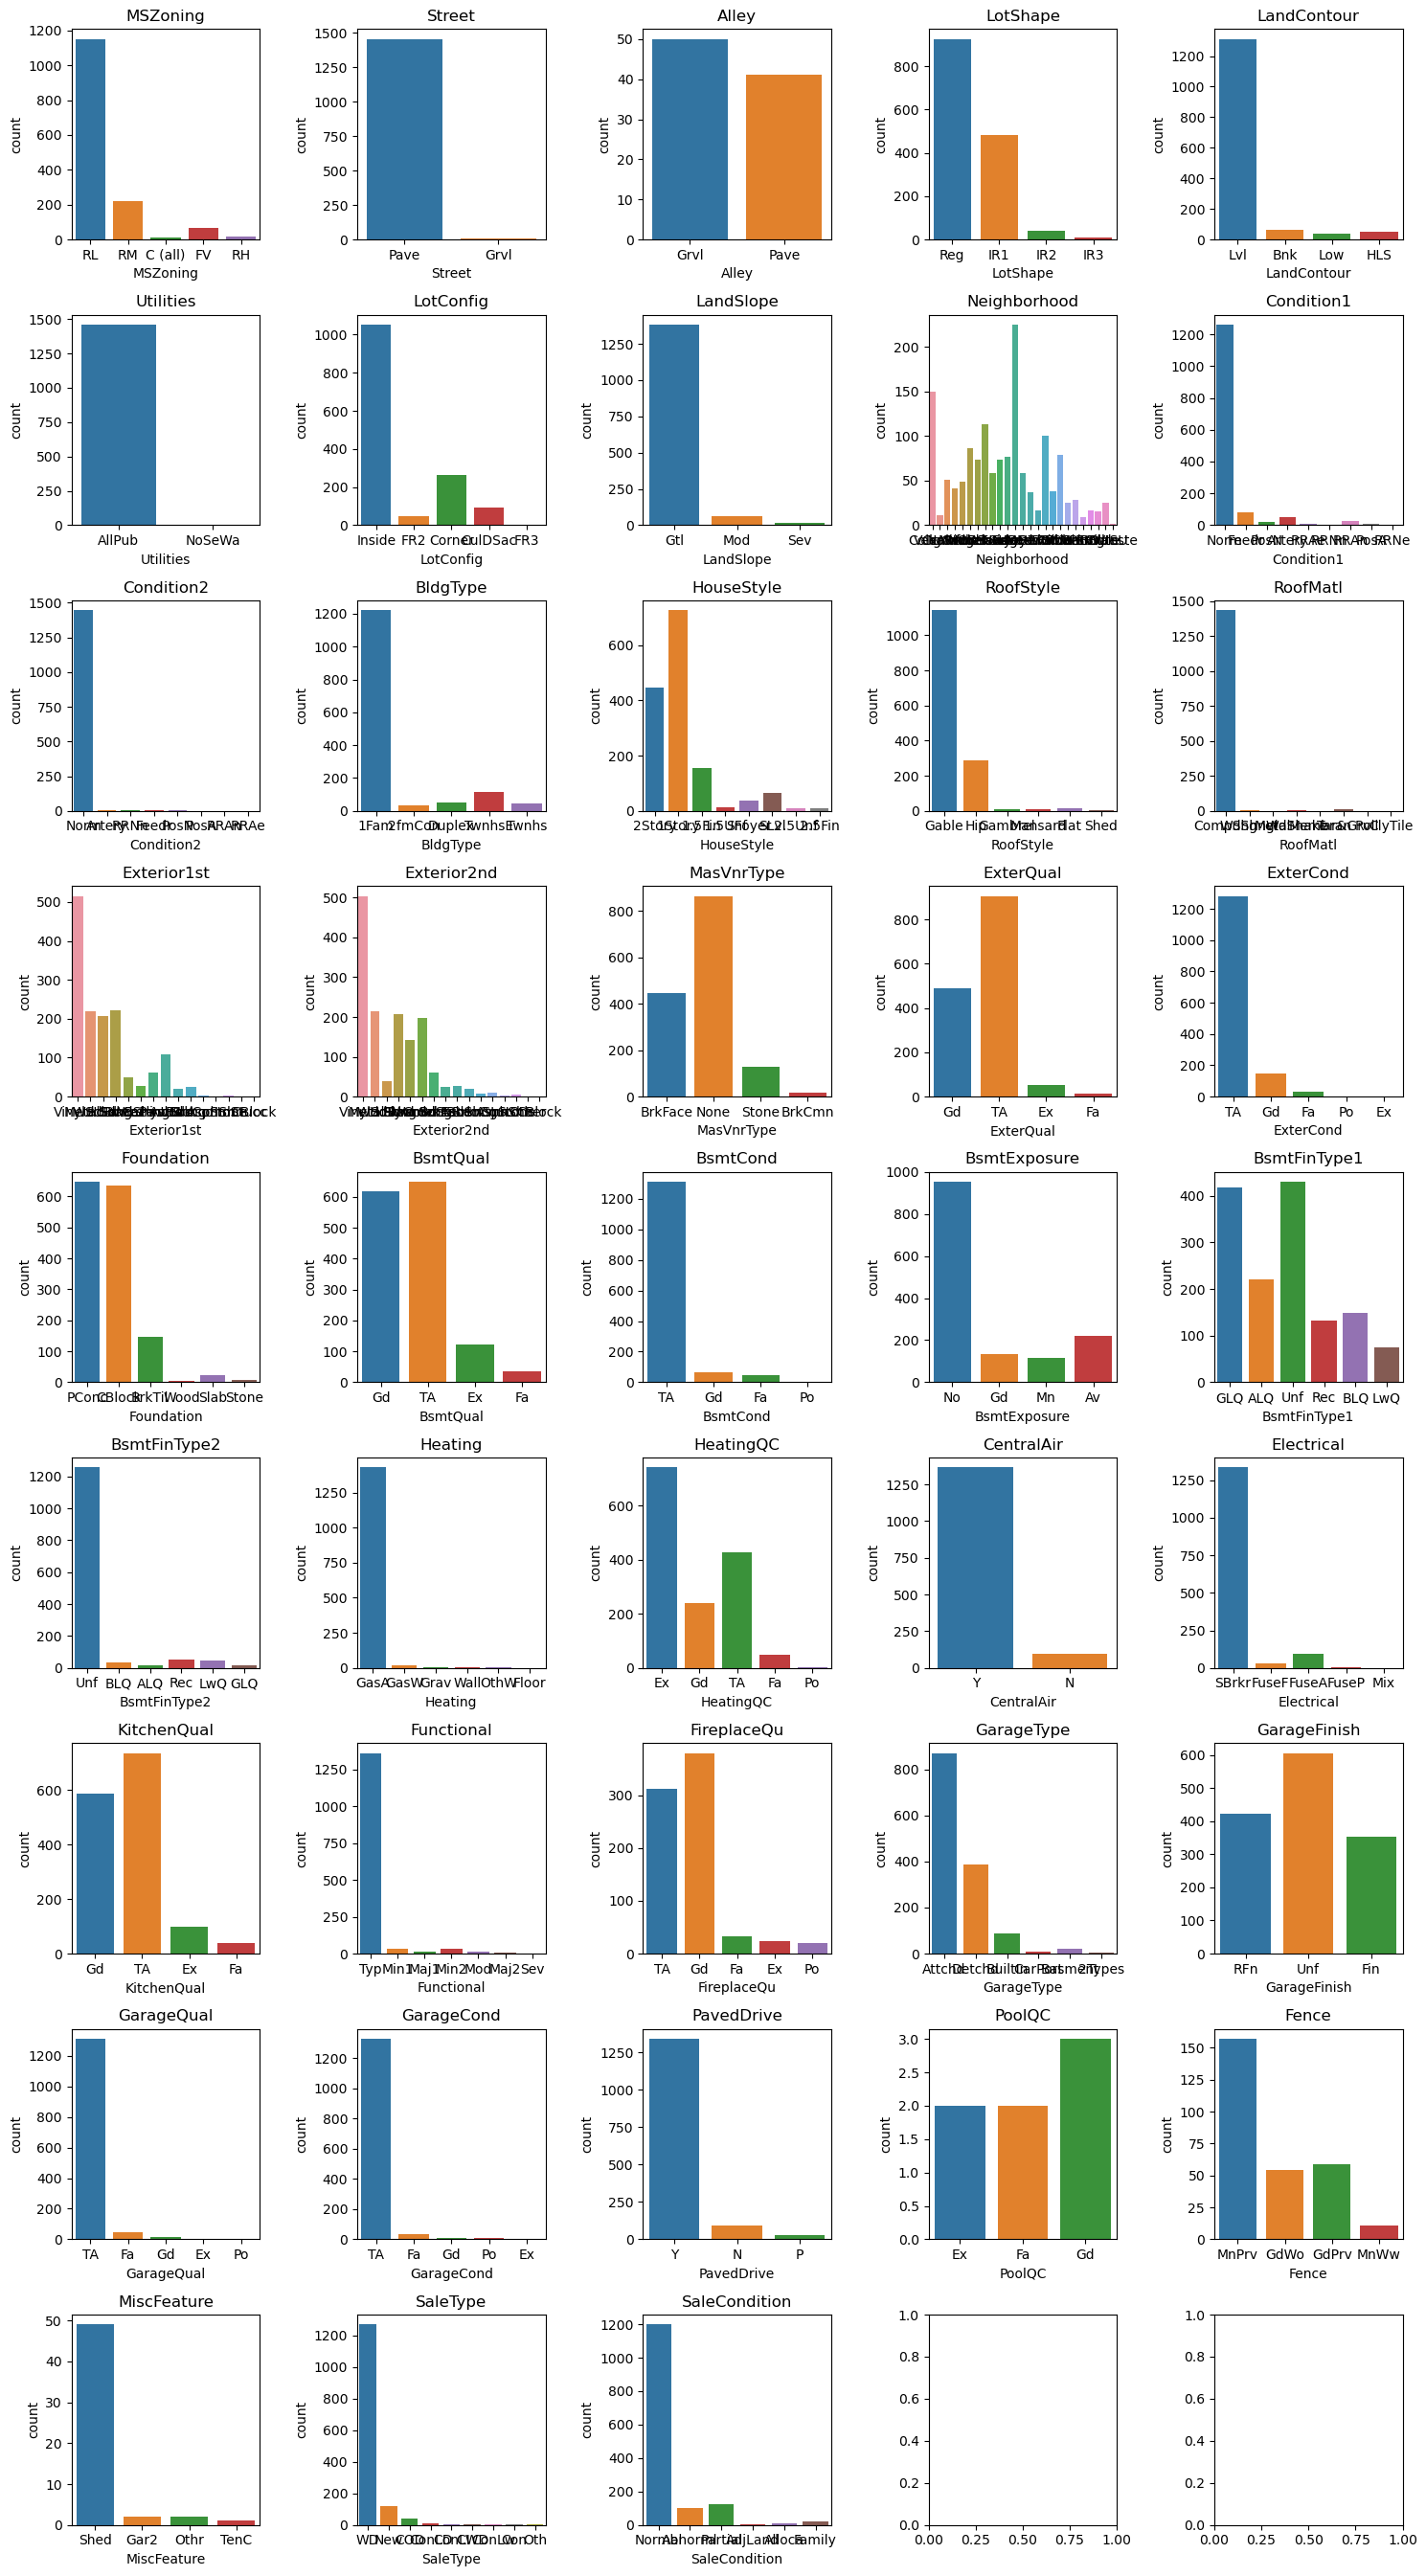

In [594]:
nrows, ncols = 9, 5
fix, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))

for i, feature in enumerate(cate_features_eda):
    # determine the location of subplot
    row, col = i // ncols, i % ncols
           
    sns.countplot(x=feature, data=train_raw, ax=axes[row, col])
    axes[row, col].set_title(feature)



plt.tight_layout()
plt.show()

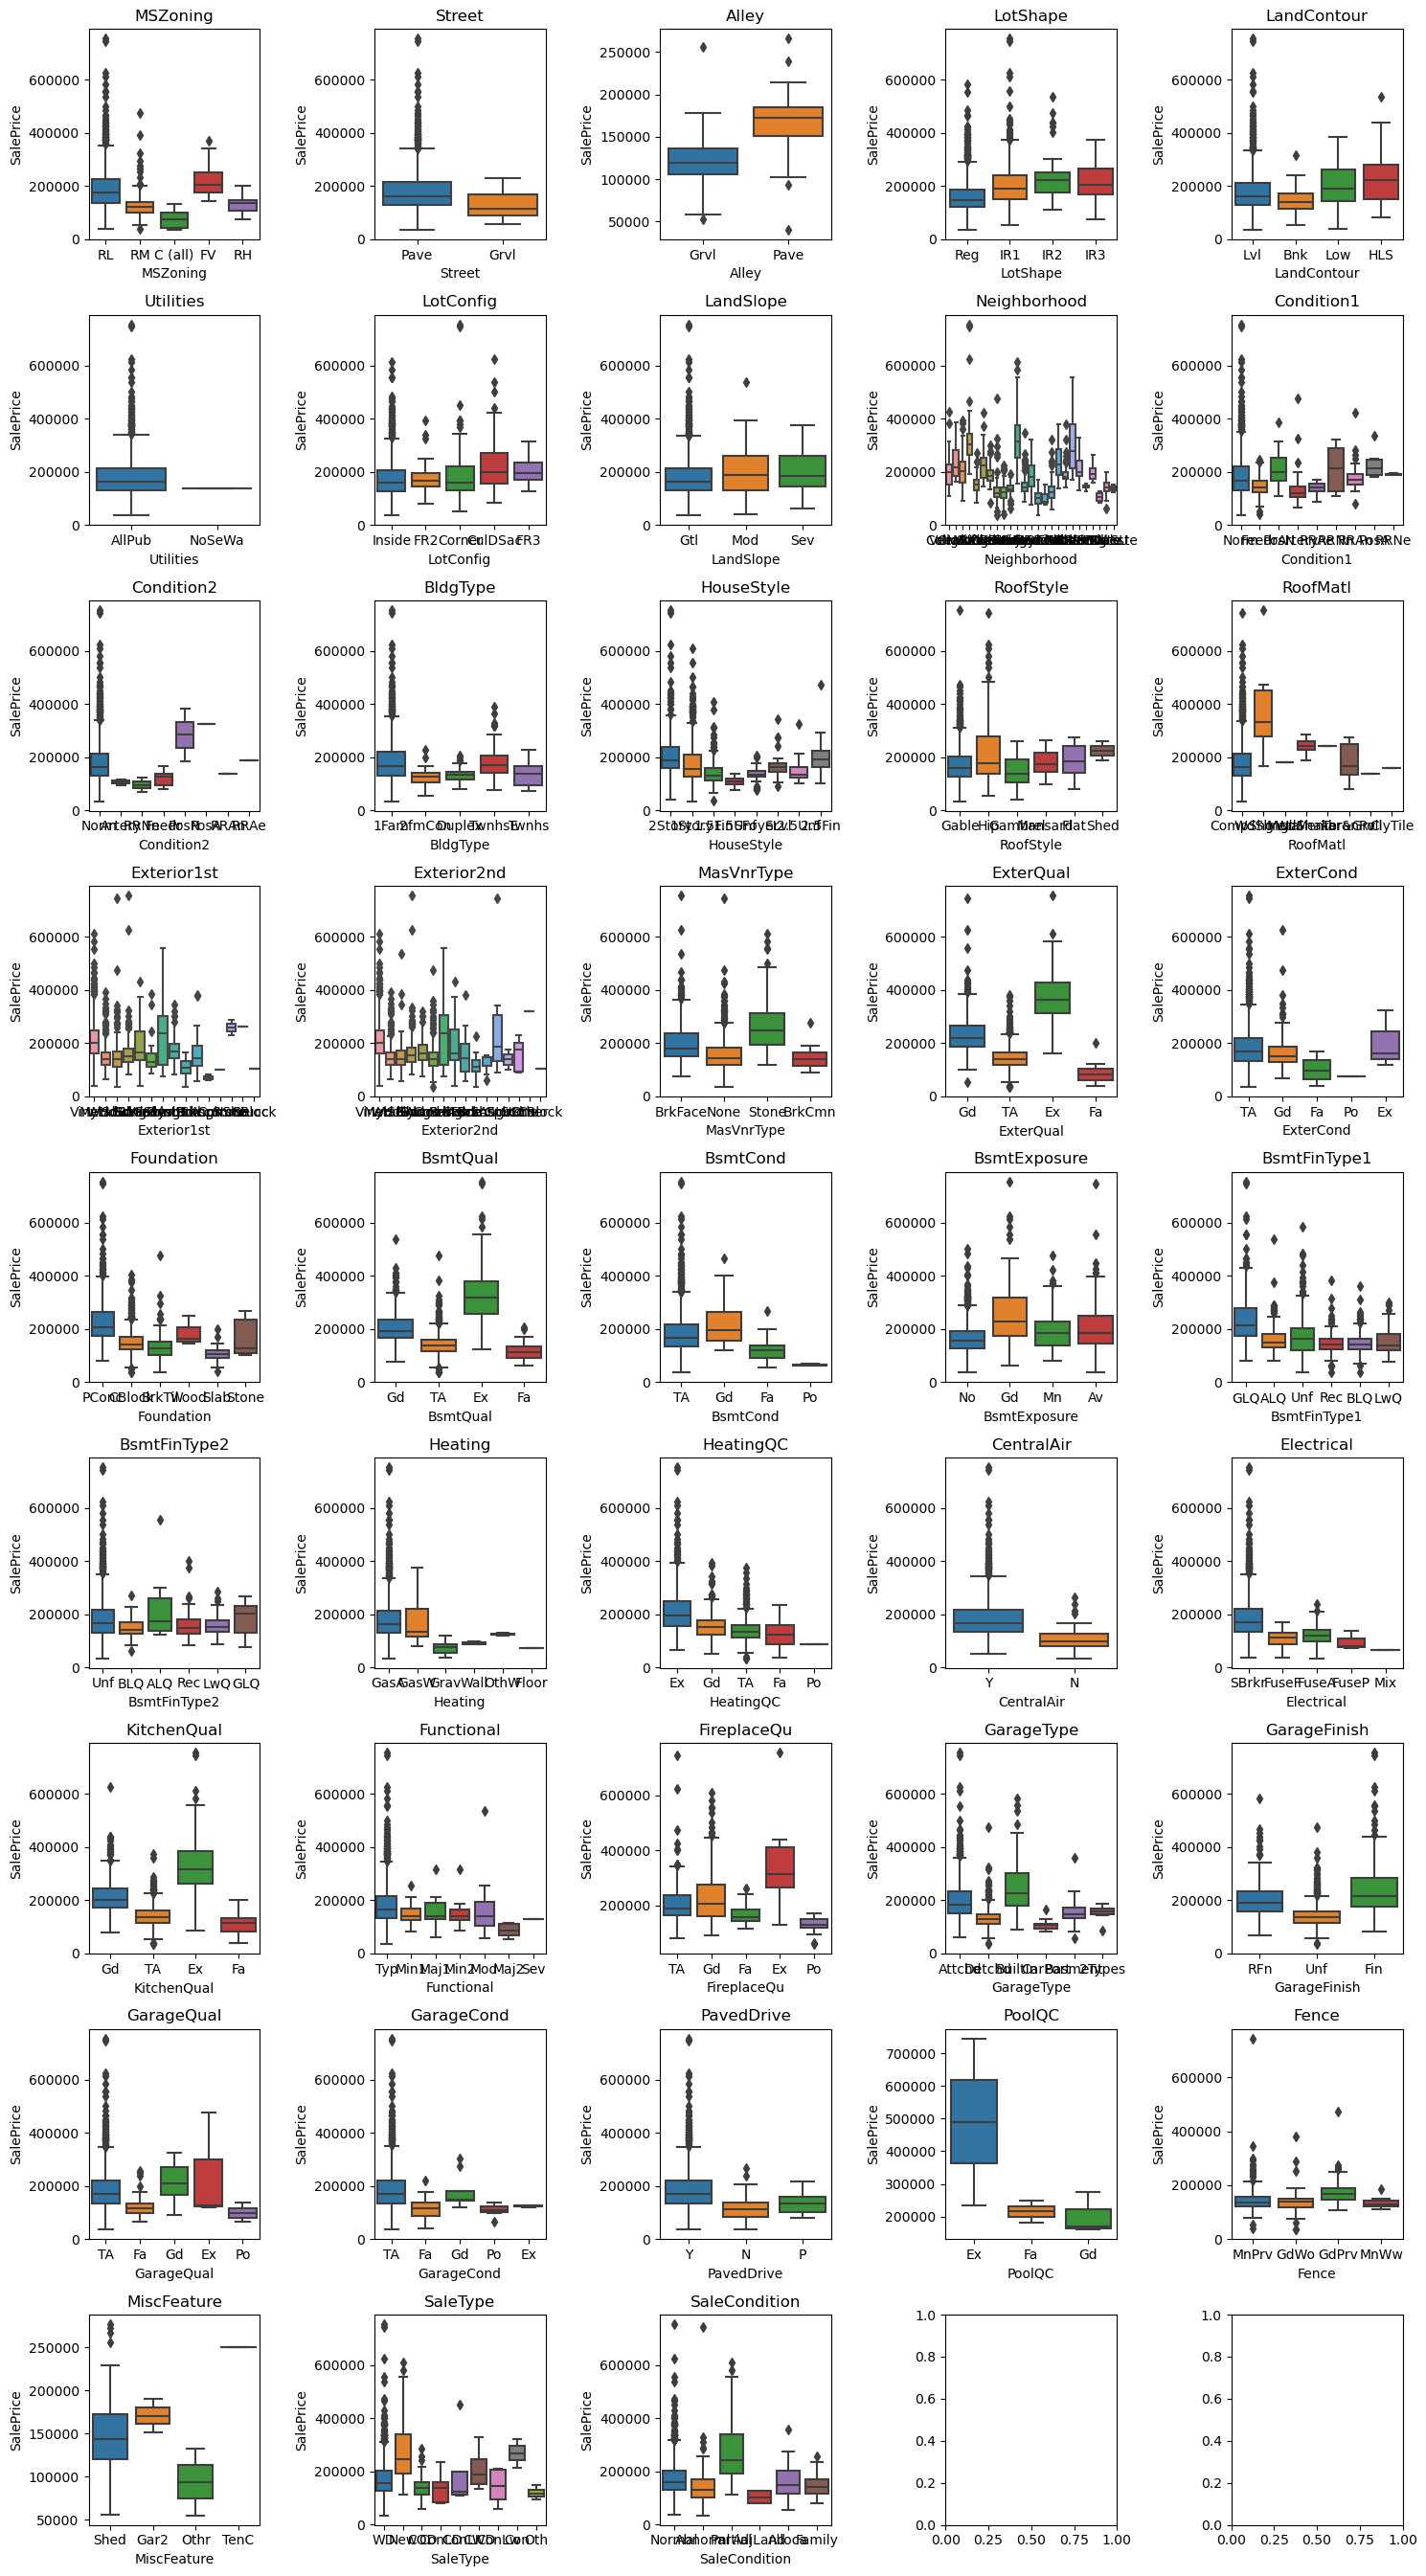

In [595]:
nrows, ncols = 9, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))

for i, feature in enumerate(cate_features_eda):
    # Determine the location of subplot
    row, col = i // ncols, i % ncols

    sns.boxplot(x=feature, y='SalePrice', data=train_raw, ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

- There is outliers in some features, we need to deal with them.

## Numerical features

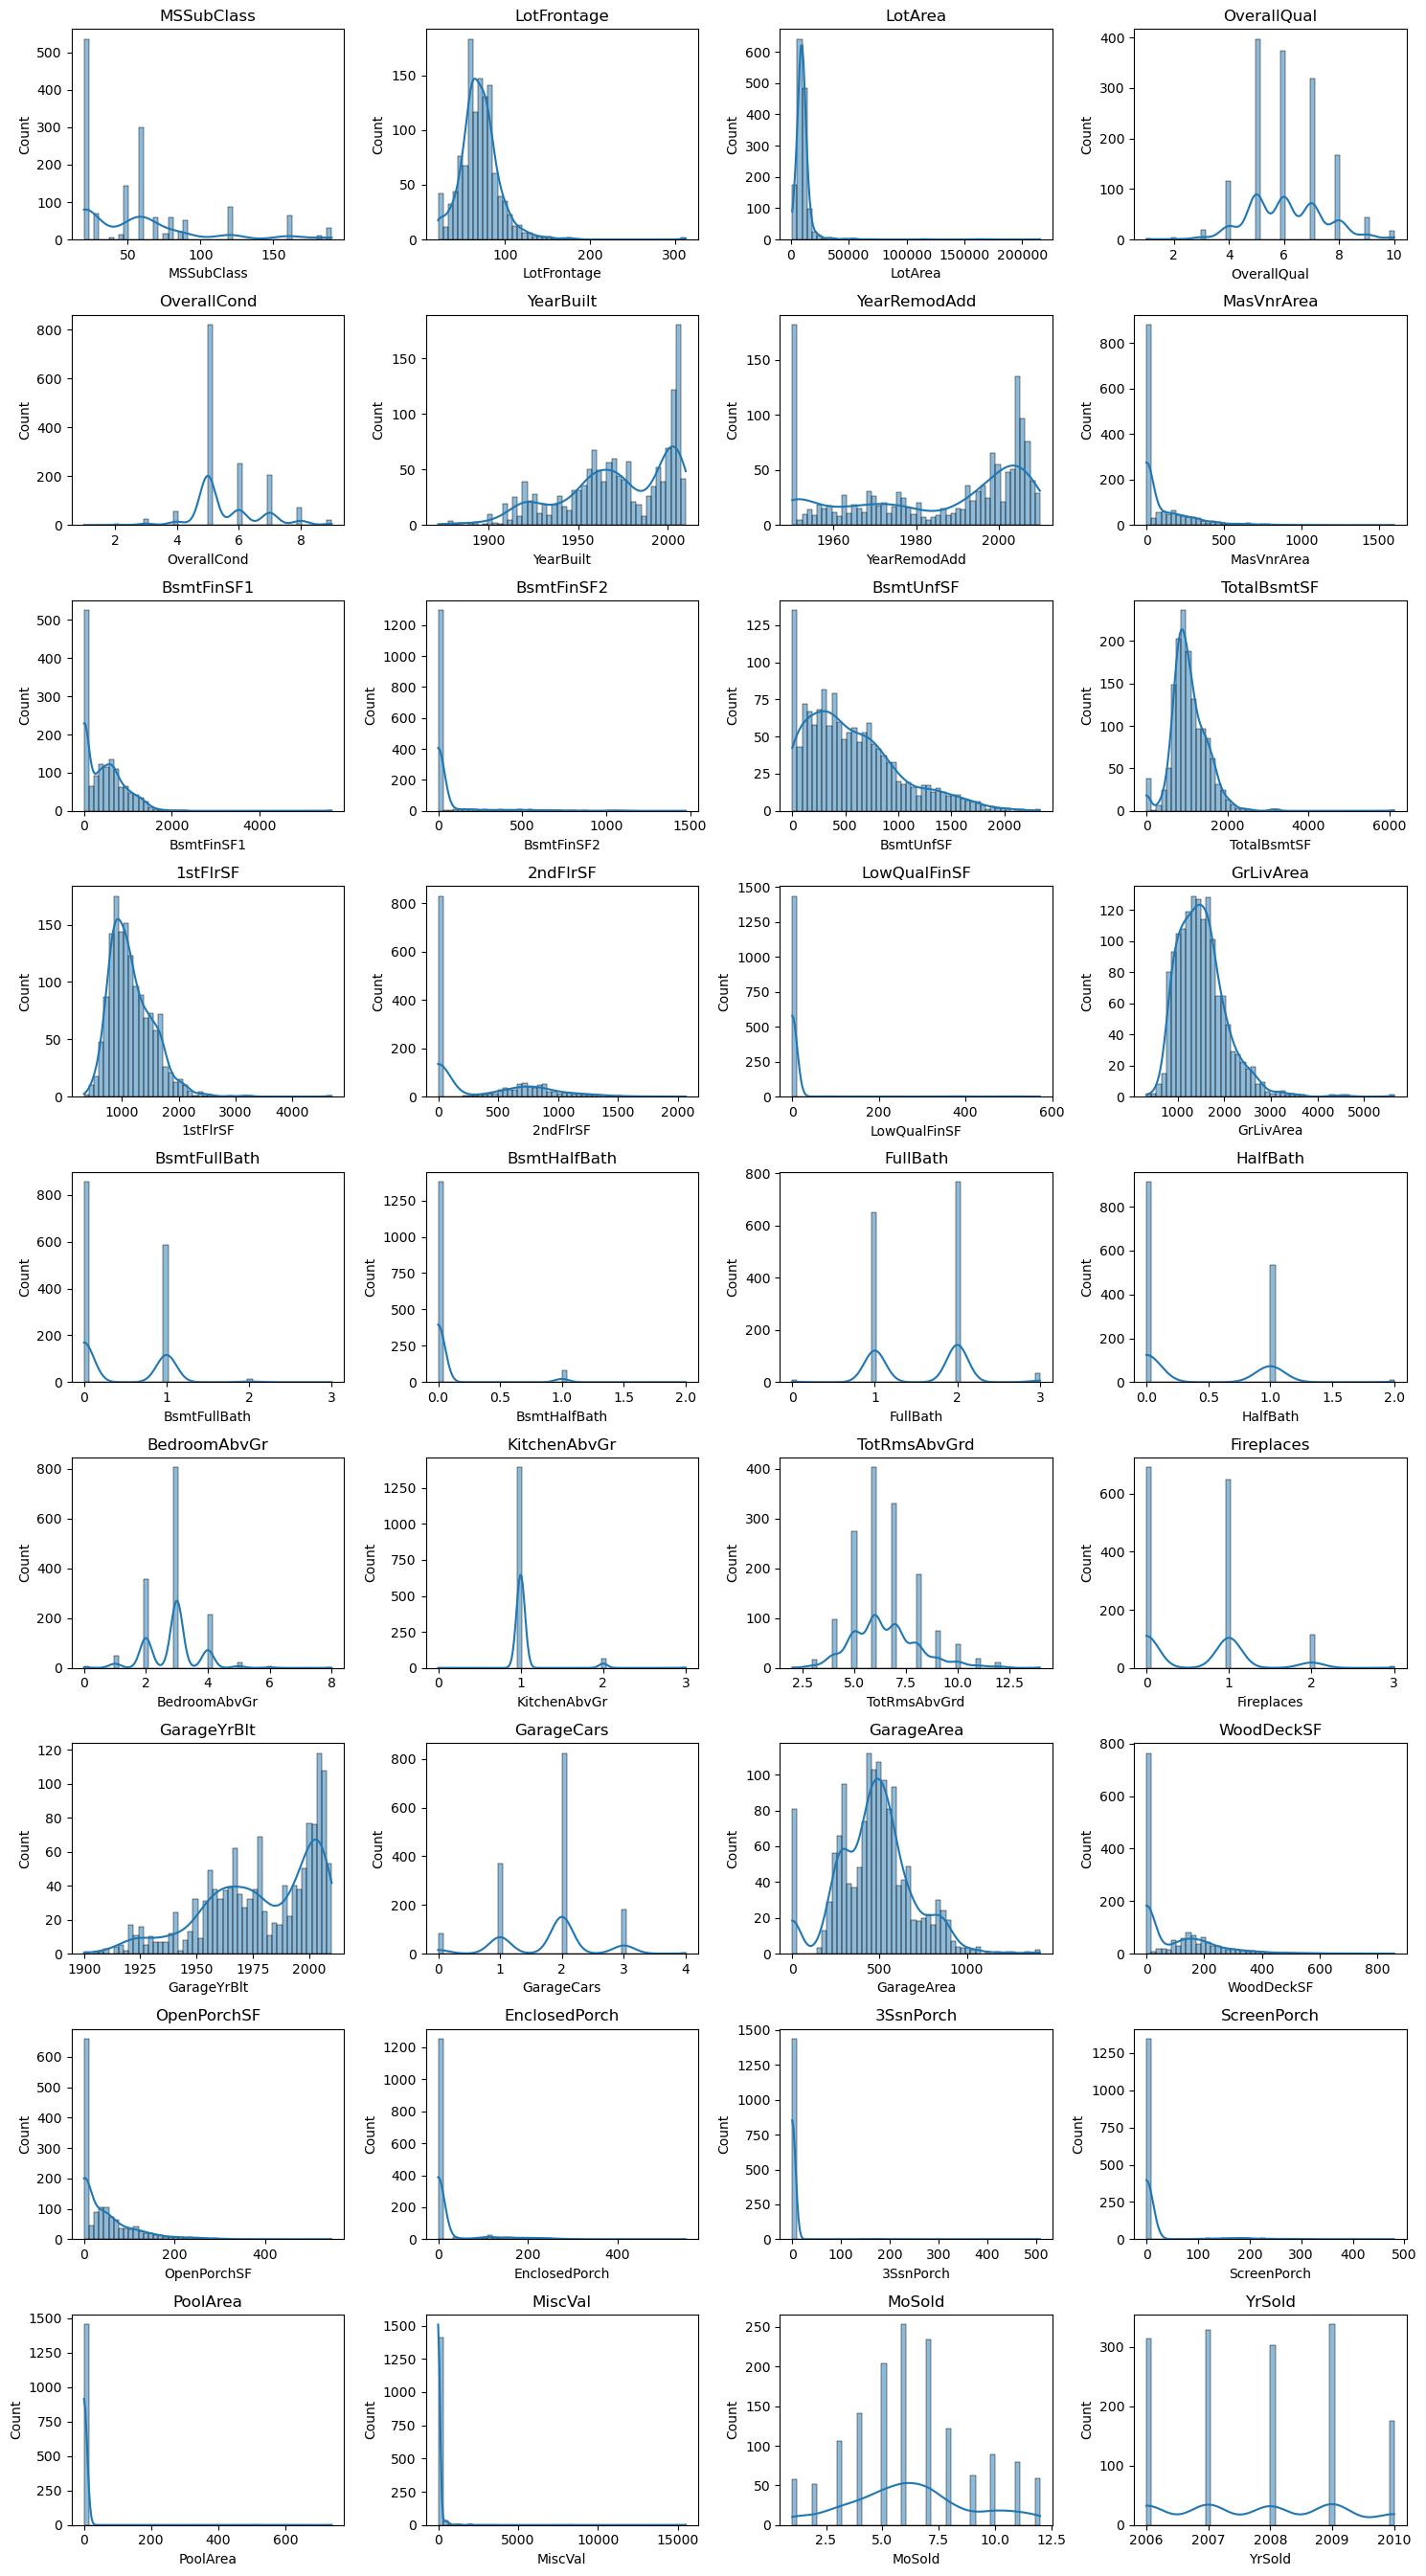

In [596]:
nrows, ncols = 9, 4
fix, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))

for i, feature in enumerate(num_features_eda):
    # determine the location of subplot
    row, col = i // ncols, i % ncols
           
    sns.histplot(train_raw[feature], bins=50, kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)



plt.tight_layout()
plt.show()

- It appears some features have lots of missing values
- Some features is skewness
- 'YearBuilt' and 'GarageYrBlt' can be encoded by label encoder

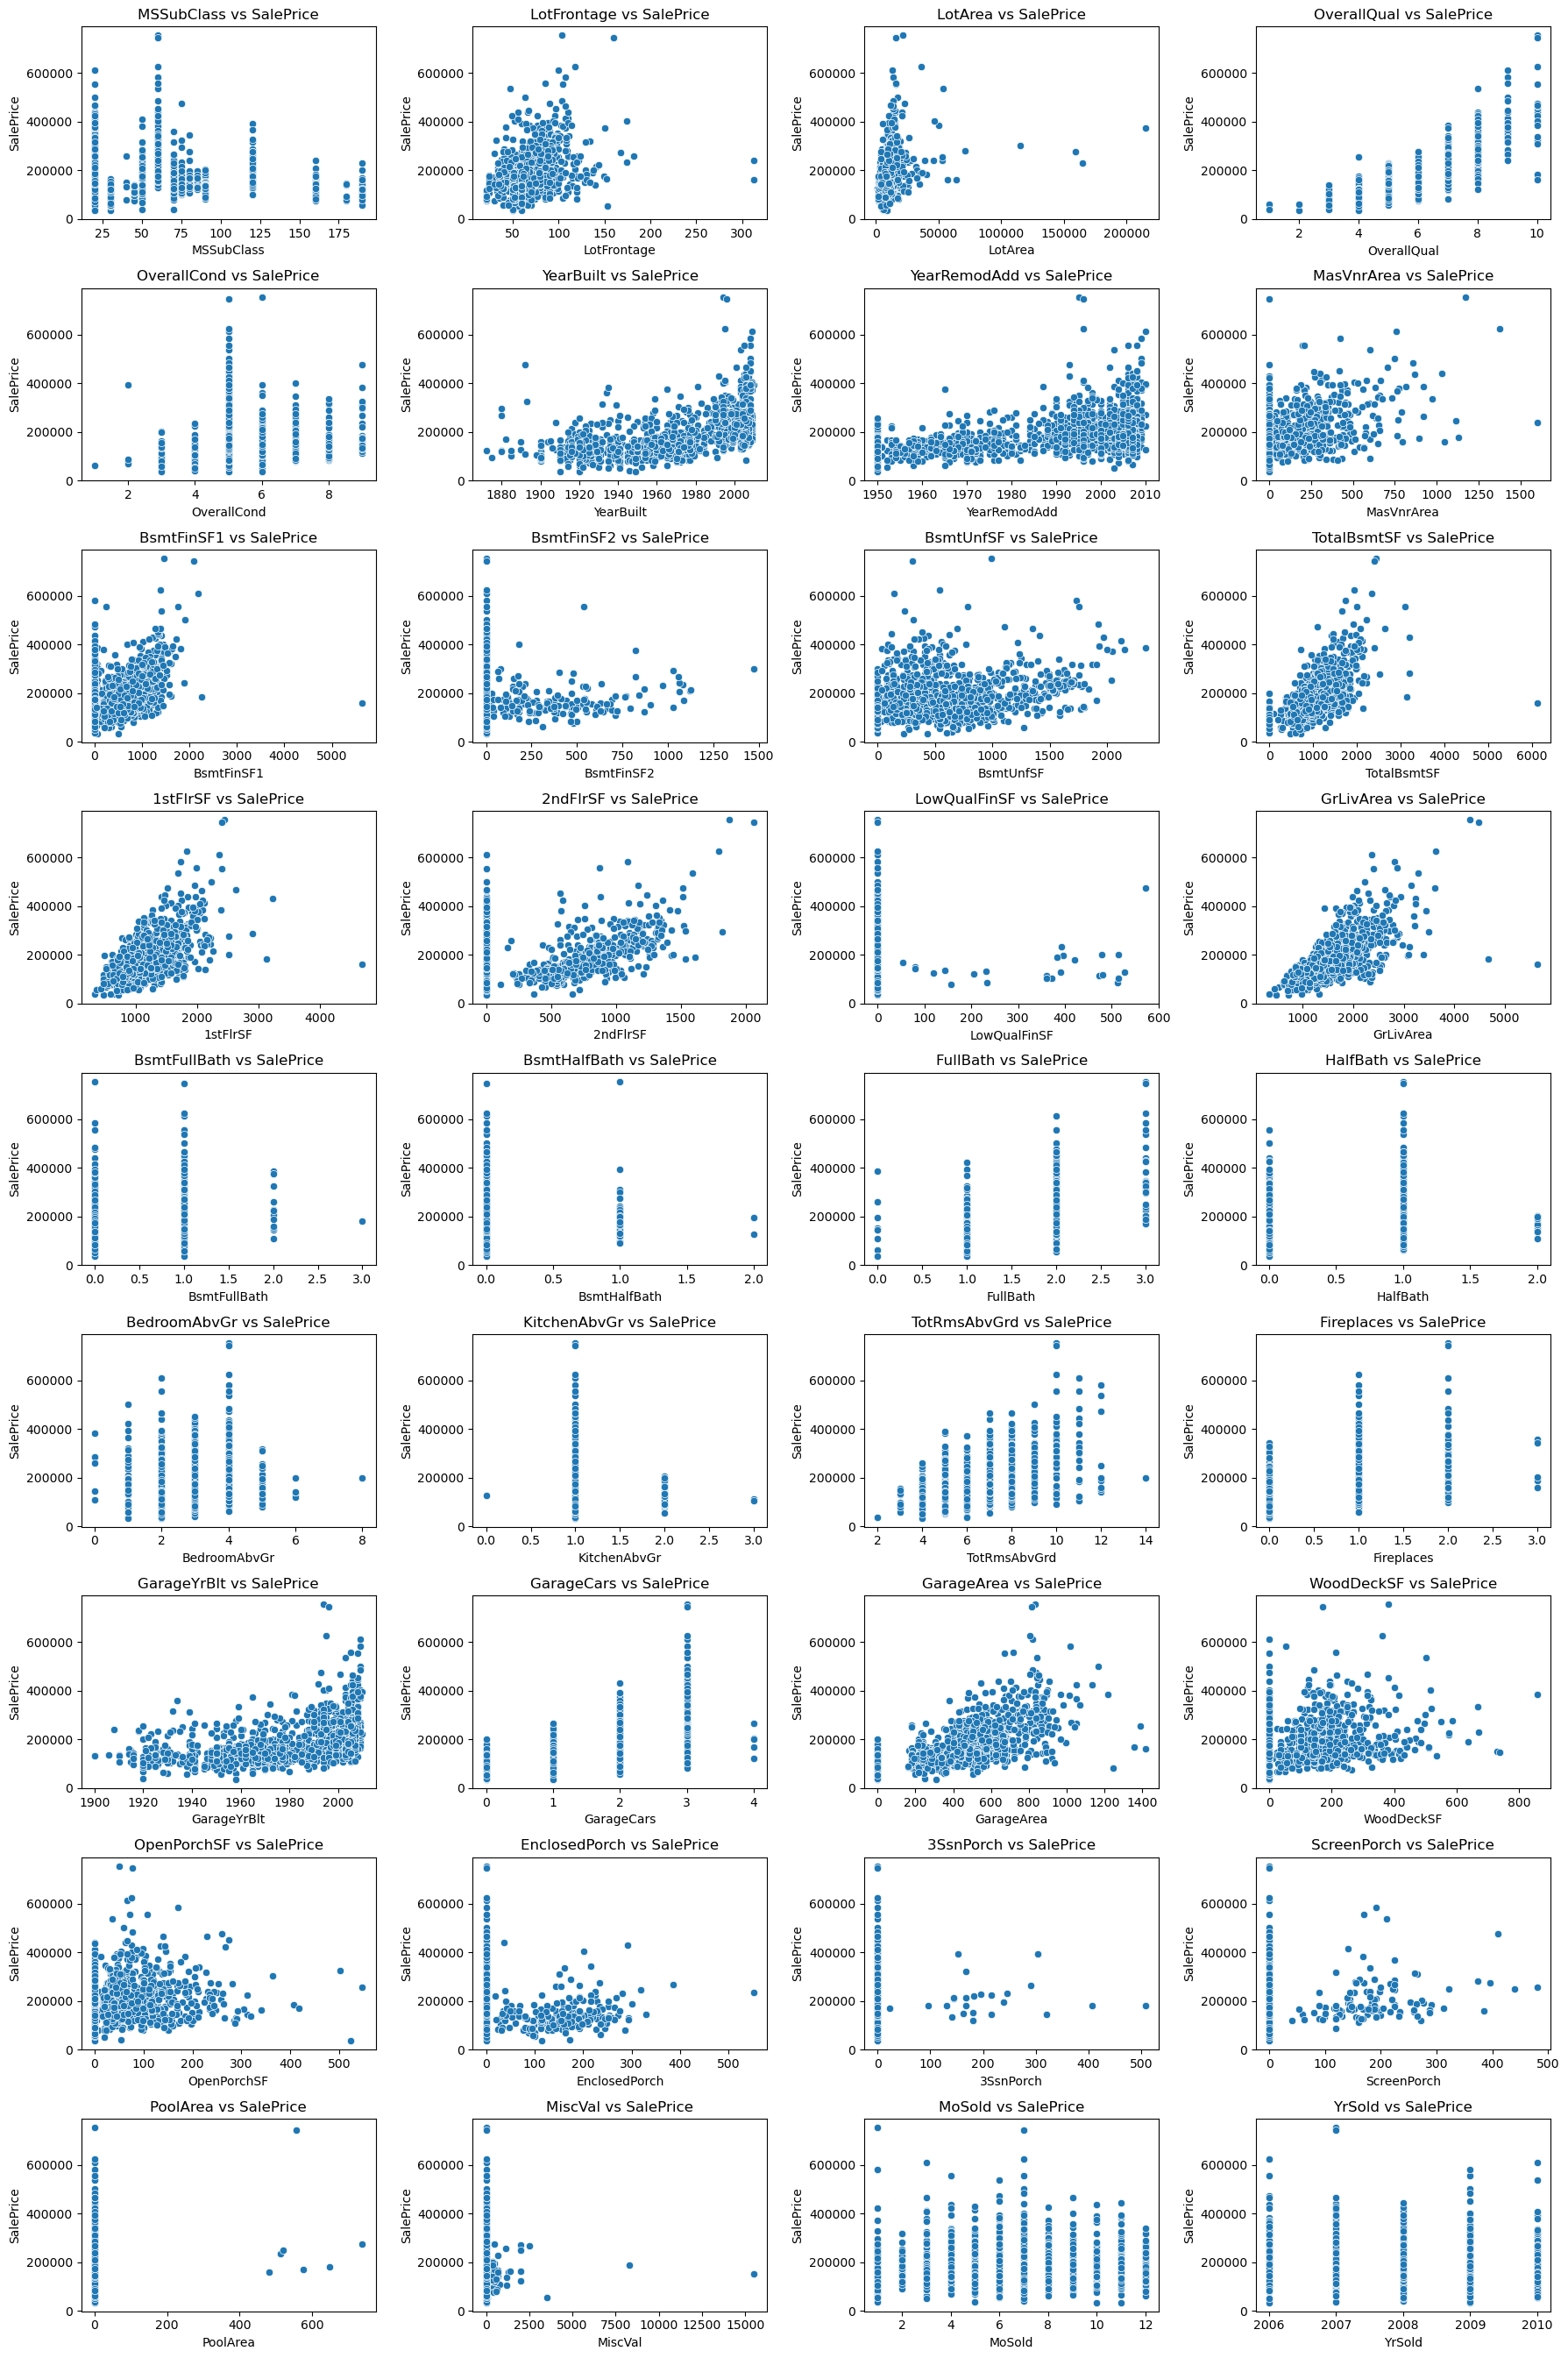

In [597]:
nrows, ncols = 9, 4
fix, axes = plt.subplots(nrows, ncols, figsize=(18, nrows * 3))

for i, feature in enumerate(num_features_eda):
    # determine the location of subplot
    row, col = i // ncols, i % ncols
           
    sns.scatterplot(x=feature, y='SalePrice', data=train_raw, ax=axes[row, col]) 
    

    
    ax=axes[row, col].set_title(f'{feature} vs SalePrice')

    
plt.tight_layout()
plt.show()

## Calculat the correlation of all features with target

### Encode categorical feature

In [598]:
def cate_encoder(df, feature_liset):

    cate_new_feature = []
    
    for feature in feature_liset:
        mean_saleprice = df.groupby([feature])['SalePrice'].mean()
        saleprice_order = pd.DataFrame(df.groupby(feature)['SalePrice'].mean()).reset_index()
        
        
        saleprice_order['rank'] = saleprice_order['SalePrice'].rank().astype(int)
        
        mapping = saleprice_order.set_index(feature)['rank'].to_dict()
        
        df[feature+'_encoded'] = df[feature].map(mapping)
        
        cate_new_feature.append(feature + '_encoded')
        
    return df, cate_new_feature

In [599]:
train_copy = train_raw.copy()
train_copy, cate_new_feature = cate_encoder(train_copy, cate_features_eda)

### Correlation

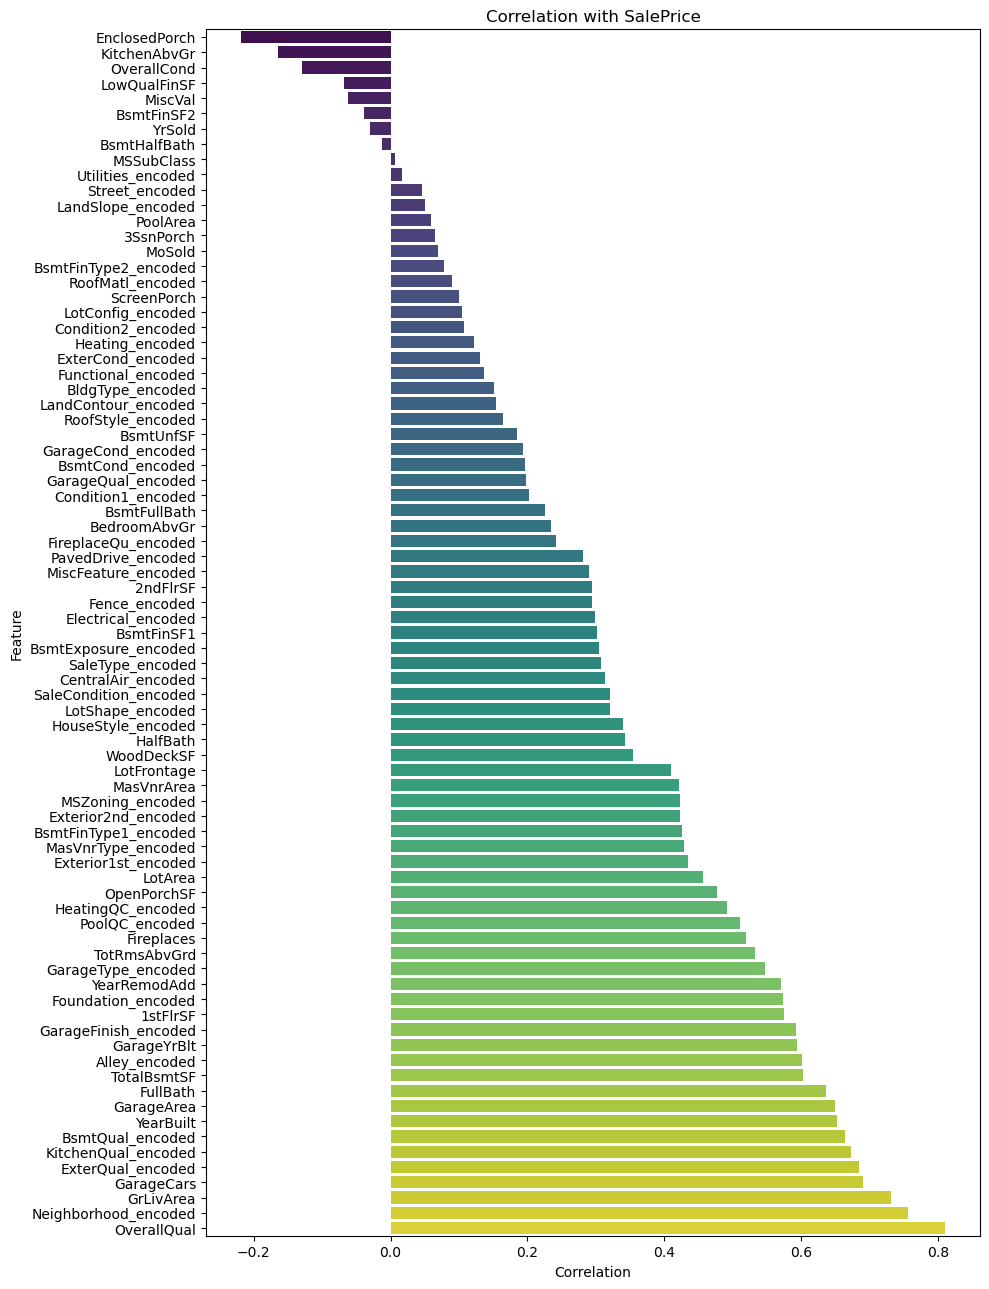

In [600]:
quantitative_features = cate_new_feature + num_features_eda + ['SalePrice']
corr_matrix = train_copy[quantitative_features].corr('spearman')
corr_df = corr_matrix['SalePrice'].reset_index()
corr_df.columns = ['Feature', 'Correlation']
corr_df = corr_df.sort_values('Correlation')
corr_df = corr_df[corr_df['Feature'] != 'SalePrice']

plt.figure(figsize=(10, 13))
sns.barplot(data=corr_df, x='Correlation', y='Feature', palette='viridis')
plt.title('Correlation with SalePrice')
plt.tight_layout()
plt.show()

# Data cleaning

## Outliers

The outliers in 'BsmtFinSF1, 'TotalBsmtSF', 'GrLivArea' will be eliminate

In [601]:
train_raw[train_raw['BsmtFinSF1'] > 4000]
# id 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [602]:
train_raw[train_raw['TotalBsmtSF'] > 4000]
# id 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [603]:
train_raw.loc[train_raw['GrLivArea'] > 4000, ['Id','GrLivArea','SalePrice']]
# id 1299 and 524

,Id,GrLivArea,SalePrice
523,524,4676,184750
691,692,4316,755000
1182,1183,4476,745000
1298,1299,5642,160000


In [604]:
train_raw = train_raw[~train_raw['Id'].isin([1299,524])]

In [605]:
train_raw.shape

(1458, 81)

# Missing values

In [606]:
df_train = train_raw.drop(['SalePrice'], axis=1)

full_data = pd.concat([df_train, test_raw], axis=0, ignore_index=True)

In [607]:
def show_missing_value_percentage(df):
    missing_data = pd.DataFrame()
    total_id = len(df)
    
    try:
        for col in df.columns:
            null_num = df[col].isnull().sum()
            if null_num > 0:
                percentage = (df[col].isnull().sum() / total_id)*100
                percentage_str = '{:.1f}%'.format(percentage)
                missing_data_temp = pd.DataFrame({'null_num': [null_num], 'Percentage': [percentage_str]}, index=[col])
                missing_data = pd.concat([missing_data, missing_data_temp], axis = 0)
        return missing_data.sort_values('null_num', ascending=False)
    except:
        print('no missing value')


In [608]:
show_missing_value_percentage(full_data)

,null_num,Percentage
PoolQC,2908,99.7%
MiscFeature,2812,96.4%
Alley,2719,93.2%
Fence,2346,80.4%
FireplaceQu,1420,48.7%
LotFrontage,486,16.7%
GarageFinish,159,5.5%
GarageQual,159,5.5%
GarageCond,159,5.5%
GarageYrBlt,159,5.5%


### Impute LotFrontage by higher correlated features and domain knowledge

featrues that high correlated with 'LotFrontage'

In [609]:
train_copy[quantitative_features].corr('spearman')['LotFrontage'].sort_values(ascending=False).head(15)

LotFrontage             1.000000
LotArea                 0.649633
1stFlrSF                0.427678
SalePrice               0.409076
TotalBsmtSF             0.386206
BldgType_encoded        0.382984
GarageArea              0.378052
GrLivArea               0.375844
TotRmsAbvGrd            0.365999
GarageCars              0.351756
GarageType_encoded      0.348671
BedroomAbvGr            0.327679
Neighborhood_encoded    0.323136
MSZoning_encoded        0.302206
GarageFinish_encoded    0.260403
Name: LotFrontage, dtype: float64

- from domain knowledge:  
    Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [610]:
full_data["LotAreaCut"] = pd.qcut(full_data.LotArea,10)
full_data['LotFrontage']=full_data.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
full_data['LotFrontage']=full_data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

### Impute other features based on the data description

Such as:  
impute the NA in PoolQC with 'None', since there is no pool

In [611]:
# impute with None
features_impute_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MSSubClass', 'MasVnrType', 'FireplaceQu']

full_data[features_impute_none] = full_data[features_impute_none].fillna('None')

In [612]:
# impute with 0
features_impute_0 = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                             'MasVnrArea']

full_data[features_impute_0] = full_data[features_impute_0].fillna(0)

In [613]:
# impute with mode
features_impute_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType','Utilities','Functional']

for feature in features_impute_mode:
    full_data[feature] = full_data[feature].fillna(full_data[feature].mode()[0])

In [614]:
show_missing_value_percentage(full_data)

no missing value


# Featrue Engineering

### Convert features into string type based on domain knowledge

In [615]:
feature_string = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
for col in feature_string:
    full_data[col] = full_data[col].astype(str)

### Label the feature based on the ranking

In [616]:
# 定义映射函数
def map_values(df):
    df['MSSubClass'] = df['MSSubClass'].map({'180':1,
                                             '30':2, '45':2,
                                             '190':3, '50':3, '90':3, 
                                             '85':4, '40':4, '160':4, 
                                             '70':5, '20':5, '75':5, '80':5, '150':5,
                                             '120': 6, '60':6})
    
    df['MSZoning'] = df['MSZoning'].map({'C (all)':1, 'RM':2, 'RH':2, 'RL':3, 'FV':4})
    
    df['Neighborhood'] = df['Neighborhood'].map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    df['HouseStyle'] = df['HouseStyle'].map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    df['MasVnrType'] = df['MasVnrType'].map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    df['ExterQual'] = df['ExterQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['ExterCond'] = df['ExterCond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['Foundation'] = df['Foundation'].map({'Slab':1, 'BrkTil':2, 'CBlock':2, 'Stone':2, 'Wood':3, 'PConc':4})
    
    df['BsmtQual'] = df['BsmtQual'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['BsmtCond'] = df['BsmtCond'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['BsmtExposure'] = df['BsmtExposure'].map({'None':1, 'No':2, 'Mn':3, 'Av':4, 'Gd':5})
    
    df['BsmtFinType1'] = df['BsmtFinType1'].map({'None':1, 'Unf':2, 'LwQ':3, 'Rec':4, 'BLQ':5, 'ALQ':6, 'GLQ':7})
    
    df['BsmtFinType2'] = df['BsmtFinType2'].map({'None':1, 'Unf':2, 'LwQ':3, 'Rec':4, 'BLQ':5, 'ALQ':6, 'GLQ':7})
    
    df['HeatingQC'] = df['HeatingQC'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['KitchenQual'] = df['KitchenQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['Functional'] = df['Functional'].map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    df['FireplaceQu'] = df['FireplaceQu'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['GarageFinish'] = df['GarageFinish'].map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    df['GarageQual'] = df['GarageQual'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['GarageCond'] = df['GarageCond'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['PavedDrive'] = df['PavedDrive'].map({'N':1, 'P':2, 'Y':3})
    
    df['PoolQC'] = df['PoolQC'].map({'None':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['Fence'] = df['Fence'].map({'None':1, 'MnWw':2, 'GdWo':3, 'MnPrv':4, 'GdPrv':5})

In [617]:
map_values(full_data)

### Label the years

In [618]:
label_encoder = LabelEncoder()
full_data['YearBuilt'] = label_encoder.fit_transform(full_data['YearBuilt'])

In [619]:
full_data['YearBuilt'] 

0       110
1        83
2       108
3        25
4       107
       ... 
2912     77
2913     77
2914     67
2915     99
2916    100
Name: YearBuilt, Length: 2917, dtype: int32

### Reduce Skewness for numerical features

In [620]:
full_data_copy = full_data.copy()

In [621]:
num_data = full_data_copy.select_dtypes(exclude='object')
skewness = num_data.skew()
skewed_features = skewness[abs(skewness) >= 1].index
full_data_copy[skewed_features] = np.log1p(full_data_copy[skewed_features])

C:\Users\Sean\AppData\Local\Temp\ipykernel_14984\481314340.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = num_data.skew()


### Transform categorical features by one-hot encoding

In [622]:
full_data.shape

(2917, 81)

In [623]:
full_data_copy = pd.get_dummies(full_data_copy)

In [624]:
# shape after one-hot encoding
full_data_copy.shape

(2917, 376)

### Scaling 

- For reducing the influence of outliers, using RobustScaler to rescale the data.
- Since the RobustSacler scale the data according to the quantile range(defaults to Interquartile Range:IQR), where IQR is the range between the 1st quartile and 3rd quartile.

In [625]:
robust_scaler = RobustScaler()

# use the train data to fit, then using the result to transform test data
train_rows = train_raw.shape[0]
train_x = full_data_copy[:train_rows]
test_x = full_data_copy[train_rows:]
train_y = train_raw['SalePrice']
# fitting
train_x = robust_scaler.fit_transform(train_x)
# transform the data based on the fitting result
test_x = robust_scaler.transform(test_x)
# rescle the target
train_y = np.log(train_y)

### Feature Selection

- Use Lasso to select feature

In [626]:
lasso = Lasso(alpha=0.001)
lasso.fit(train_x, train_y)

Lasso(alpha=0.001)

In [627]:
lasso_fi = pd.DataFrame({'feature_importance':lasso.coef_}, index=full_data_copy.columns)

In [628]:
lasso_fi.sort_values('feature_importance', ascending=False)

,feature_importance
OverallQual,0.113455
GrLivArea,0.102928
2ndFlrSF,0.082697
YearBuilt,0.071895
1stFlrSF,0.060276
...,...
Condition1_Artery,-0.007887
BsmtUnfSF,-0.008488
"LotAreaCut_(9452.0, 10148.8]",-0.010590
CentralAir_N,-0.038244


<Figure size 640x480 with 0 Axes>

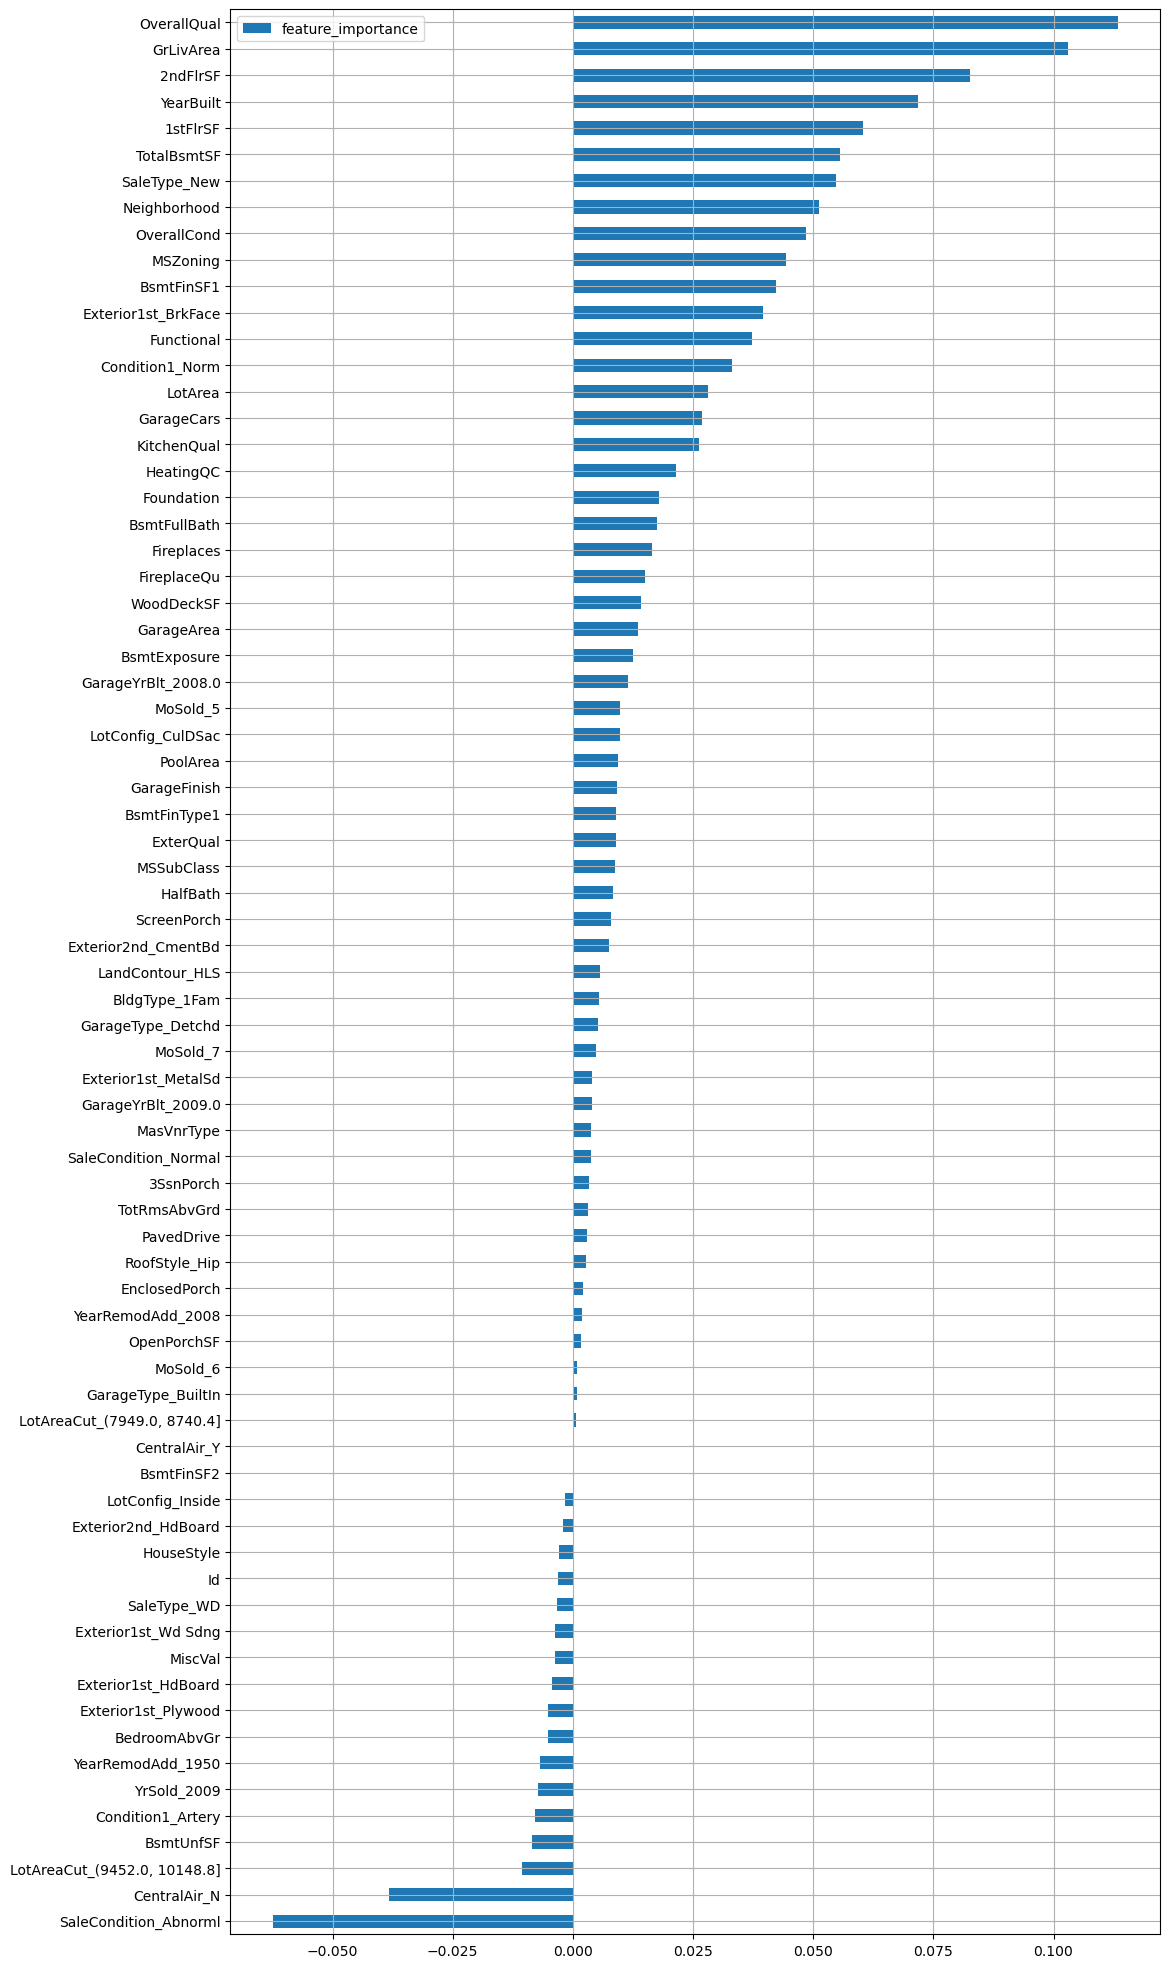

In [629]:
plt.figure()
lasso_fi[lasso_fi['feature_importance'] != 0].sort_values('feature_importance').plot(kind='barh', figsize=(12, 25))
plt.grid()
plt.show()

In [630]:
def add_feature(X):
    X['TotalHouse'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
    X['TotalArea'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'] + X['GarageArea']
    X['TotalQuality'] = X['OverallQual'] + X['OverallCond']
    
    X['TotalHouse_OverallQual'] = X['TotalHouse'] * X['OverallQual']
    X['GrLivArea_OverallQual'] = X['GrLivArea'] * X['OverallQual']
    X['MSZoning_TotalHouse'] = X['MSZoning'] * X['TotalHouse']
    X['MSZoning_OverallQual'] = X['MSZoning'] + X['OverallQual']
    X['MSZoning_YearBuilt'] = X['MSZoning'] + X['YearBuilt']
    X['Neighborhood_TotalHouse'] = X['Neighborhood'] * X['TotalHouse']
    X['Neighborhood_OverallQual'] = X['Neighborhood'] + X['OverallQual']
    X['Neighborhood_YearBuilt'] = X['Neighborhood'] + X['YearBuilt']
    X['BsmtFinSF1_OverallQual'] = X['BsmtFinSF1'] * X['OverallQual']
    X['Functional_TotalHouse'] = X['Functional'] * X['TotalHouse']
    X['Functional_OverallQual'] = X['Functional'] + X['OverallQual']
    X['LotArea_OverallQual'] = X['LotArea'] * X['OverallQual']
    X['LotArea_TotalHouse'] = X['LotArea'] + X['TotalHouse']
    
    X['Bsmt'] = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['BsmtUnfSF']
    X['PorchArea'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
    
    X['TotalPlace'] = X['TotalArea'] + X['PorchArea']

In [631]:
add_feature(full_data_copy)

In [632]:
num_data = full_data_copy_2.select_dtypes(exclude='object')
skewness = num_data.skew()
skewed_features = skewness[abs(skewness) >= 1].index
full_data_copy_2[skewed_features] = np.log1p(full_data_copy_2[skewed_features])

c:\Users\Sean\anaconda3\lib\site-packages\pandas\core\nanops.py:1226: RuntimeWarning: overflow encountered in multiply
  result = (count * (count - 1) ** 0.5 / (count - 2)) * (m3 / m2**1.5)


In [633]:
full_data_copy = pd.get_dummies(full_data_copy)

In [634]:
robust_scaler = RobustScaler()

# use the train data to fit, then using the result to transform test data
train_rows = train_raw.shape[0]
train_x = full_data_copy[:train_rows]
test_x = full_data_copy[train_rows:]
train_y = train_raw['SalePrice']
# fitting
train_x = robust_scaler.fit_transform(train_x)
# transform the data based on the fitting result
test_x = robust_scaler.transform(test_x)
# rescle the target
train_y = np.log(train_y)

In [635]:
train_x.shape, test_x.shape, train_y.shape

((1458, 395), (1459, 395), (1458,))

In [636]:
pca = PCA()
pca.fit(train_x)

# Calculate the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of components based on the desired level of explained variance
desired_variance = 0.95  # Change this value for the desired level of explained variance
n_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1

print("Number of components to achieve {:.2f} explained variance: {}".format(desired_variance, n_components))

Number of components to achieve 0.95 explained variance: 84


In [637]:
pca = PCA(n_components=84)

In [638]:
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

In [639]:
train_x.shape, test_x.shape

((1458, 84), (1459, 84))

# Model Building and Evaluation

- Since the target is numerical , we use RMSE to evaluate the model performance

In [640]:
def rmse_cv(model, x, y):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

**Using following models**

- LinearRegression
- Ridge
- Lasso
- Random Forrest
- Gradient Boosting Tree
- Support Vector Regression
- Linear Support Vector Regression
- ElasticNet
- Stochastic Gradient Descent
- BayesianRidge
- KernelRidge
- ExtraTreesRegressor
- XgBoost

In [641]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]

In [642]:
cv_results = pd.DataFrame()

for name, model in zip(names, models):
    score = rmse_cv(model, train_x, train_y)
    mean_score = score.mean()
    
    temp = pd.DataFrame(
        {'Model': [name], 'Score': [mean_score]}
    )
    cv_results = pd.concat([cv_results, temp], axis=0)
    

c:\Users\Sean\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Sean\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Sean\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Sean\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Sean\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [643]:
cv_results.sort_values('Score')

,Model,Score
0,Ker,0.111734
0,Ela,0.113148
0,Bay,0.113288
0,Ridge,0.114135
0,LR,0.114198
0,LinSVR,0.116816
0,Lasso,0.126099
0,GBR,0.127066
0,Extra,0.129977
0,RF,0.134245


### Use GridSearchCV to find the best composition of hyperparameters

In [644]:
def grid(model, X, y, params):
    grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)
    print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))

In [645]:
params_lasso = {'alpha': [0.0004,0.0005,0.0007,0.0009], 'max_iter':[10000]}
grid(Lasso(), train_x, train_y, params_lasso)

{'alpha': 0.0007, 'max_iter': 10000} 0.11329646171758367


In [646]:
params_ridge = {'alpha':[35,40,45,50,55,60,65,70,80,90]}
grid(Ridge(), train_x, train_y, params_ridge)

{'alpha': 45} 0.1132993899283997


In [647]:
params_ker = {'alpha':[0.2,0.3,0.4], 
              'kernel':["polynomial"], 
              'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge(), train_x, train_y, params_ker)

{'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} 0.11847522432820264


In [648]:
params_ela = {'alpha':[0.0008,0.004,0.005],
              'l1_ratio':[0.08,0.1,0.3],
              'max_iter':[10000]}
grid(ElasticNet(), train_x, train_y, params_ela)

{'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': 10000} 0.11325202022974261


In [649]:
params_svr = {'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}
grid(SVR(), train_x, train_y, params_svr)

{'C': 15, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.11161992391200727


In [650]:
lasso = Lasso(alpha=0.0009, max_iter=10000)
ridge = Ridge(alpha=55)
#svr = SVR(C=15, epsilon=0.008, gamma= 0.0004, kernel='rbf')
ker = KernelRidge(alpha=0.4, coef0=1, degree=3, kernel='polynomial')
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

## Ensemble Training

### Weighting of each model

In [651]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self, mods, weight):
        self.mods = mods
        self.weight = weight
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.mods]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        results = [model.predict(X) for model in self.models_]
        
        pre = np.dot(np.array(self.weight), np.array(results))
        return pre

In [656]:
model_weight = [0.05, 0.3, 0.45, 0.03, 0.17]
models = [lasso, ridge, ker, ela, bay]
avg_w = AverageWeight(models, model_weight)
avg_score = rmse_cv(avg_w, train_x, train_y)
print(avg_score.mean())

0.11090358511971225


In [657]:
avg_w.fit( train_x, train_y)

AverageWeight(mods=[Lasso(alpha=0.0009, max_iter=10000), Ridge(alpha=55),
                    KernelRidge(alpha=0.4, kernel='polynomial'),
                    ElasticNet(alpha=0.005, l1_ratio=0.08, max_iter=10000),
                    BayesianRidge()],
              weight=[0.05, 0.3, 0.45, 0.03, 0.17])

# Prediction

In [658]:
y_pred = np.exp(avg_w.predict(test_x))

In [659]:
result = pd.DataFrame({'Id':test_raw['Id'], 'SalePrice':y_pred})
result.to_csv('submission_avg.csv', index=False)
